In [1]:
import pandas as pd
import keras
from pickle import dump
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from numpy import array
import tensorflow
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


In [2]:
cap = pd.read_csv('img_caption.csv')
cap.head(20)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


## Importing all the save pickled files after preprocessing

In [7]:
features = load(open('features.pkl', 'rb'))
tokenizer = load(open('tokenizer.pkl', 'rb'))
corpus = load(open('corpus.pkl', 'rb'))
word_vector_matrix = load(open('word_vector_matrix.pkl', 'rb'))

In [67]:
features

{'1000268201_693b08cb0e': array([[0.09043565, 0.51620364, 0.01783604, ..., 0.04799875, 0.27252492,
         1.0266767 ]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.9854582 , 1.1423899 , 0.3334711 , ..., 0.3116553 , 0.1497841 ,
         0.26873136]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.3546673 , 0.80218446, 0.00292251, ..., 0.        , 1.1219509 ,
         0.21739756]], dtype=float32),
 '1003163366_44323f5815': array([[0.48568422, 0.11777057, 0.8198075 , ..., 0.26790565, 0.0146264 ,
         0.01374183]], dtype=float32),
 '1007129816_e794419615': array([[0.37315443, 2.4181557 , 0.        , ..., 0.11245298, 0.        ,
         0.12874338]], dtype=float32),
 '1007320043_627395c3d8': array([[2.1283596 , 0.7958995 , 0.01277889, ..., 0.        , 0.13793963,
         0.00524671]], dtype=float32),
 '1009434119_febe49276a': array([[0.47985333, 0.13765608, 0.33705804, ..., 0.15243258, 0.08318652,
         0.01949844]], dtype=float32),
 '1012212859_01547e3f17': array([[

## Maximum length of the sequence is set to be = 34
## Vocabulary size is obtained from tokenizer.word_index

In [8]:
max_length = 34
voc_size = len(tokenizer.word_index) + 1

In [9]:
voc_size

6481

## Getting the pre trained word embedding from Glove 200D

In [ ]:
# the  [-0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092]

In [8]:
Initializing glove_vectors dict

glove_vectors = dict()

file = open('glove.6B.200d.txt',encoding ='utf-8')
i=0
for line in file:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:])
    glove_vectors[word] = vectors

file.close()

## Get the glove vector for each word in tokenizer.word_index

In [9]:
word_vector_matrix = np.zeros([voc_size,200])

for word,index in tokenizer.word_index.items():
    vector = glove_vectors.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector

        

## saving 'word_vector_matrix' to use in embedding layer

In [10]:
#dump(word_vector_matrix, open('word_vector_matrix.pkl', 'wb'))
np.shape(word_vector_matrix)


(6481, 200)

## Making an array containing the features obtained through Resnet 50

In [11]:
cnn_features = []

for img,cptn in features.items():   
    cnn_feature = features.get(img)
    cnn_features.append(cnn_feature.reshape([2048]))

In [12]:
 np.shape(cnn_features)   # 8091 - images  # 2048 - length of features

(8091, 2048)

## Define the captioning model

In [19]:
def define_model(vocab_size, max_length):
    
    vec_size = 200
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, vec_size, mask_zero=True,weights =[word_vector_matrix], trainable = False )(inputs2)## 100 was previously 256
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    
    return model

## Making training set for Neural Network model

In [13]:


X1=[] 
X2, y = list(), list()
j=0
# walk through each description for the image
for desc in corpus:
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        
        # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=voc_size)[0]
        # store
        X1.append(cnn_features[j][:])
        X2.append(in_seq)
        y.append(out_seq)
    j=j+1   


In [14]:
X1=np.array(X1)
X2=np.array(X2)
y=np.array(y)



print(np.shape(X1))
print(np.shape(X2))
print(np.shape(y))

(258256, 2048)
(258256, 34)
(258256, 6481)


In [ ]:
# Saving this large array in parts, so that systems RAM can handel
for i in range(0,25):
    dump(X1[i:((i+1)*10000),:], open('Pickled_files\X1_{}.pkl'.format(i), 'wb'))
    dump(X2[i:((i+1)*10000),:], open('Pickled_files\X2_{}.pkl'.format(i), 'wb'))
    dump(y[i:((i+1)*10000),:], open('Pickled_files\y_{}.pkl'.format(i), 'wb'))

## Initializing the Model

In [20]:
max_length = max_length
vocab_size = voc_size 

# train the model
model = define_model(vocab_size, max_length)

#model.load_weights("model_weights_resnet.h5")           #if the weights are obtained from anywhere else

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1296200     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

## Start the training

In [131]:

for i in range(0,15):
    X1 = load(open('Pickled_files\X1_{}.pkl'.format(i), 'rb'))
    X2 = load(open('Pickled_files\X2_{}.pkl'.format(i), 'rb'))
    y = load(open('Pickled_files\y_{}.pkl'.format(i), 'rb'))

    n=10000
    X_train = [X1[0:n,:],X2[0:n,:]]
    y_train = y[0:n,:]
    #X_test = [X1[n:n+200,:],X2[n:n+200,:]]
    #y_test= y[n:n+200,:]

    #model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)
    model.fit(X_train,y_train,epochs=5,batch_size=64)

Epoch 1/5
10000/10000 [==============================] - 25s 3ms/step - loss: 0.3279
Epoch 2/5
10000/10000 [==============================] - 25s 3ms/step - loss: 0.2990
Epoch 3/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.2923
Epoch 4/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.2755
Epoch 5/5
10000/10000 [==============================] - 23s 2ms/step - loss: 0.2390
Epoch 1/5
10000/10000 [==============================] - 25s 3ms/step - loss: 0.2344
Epoch 2/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.2159
Epoch 3/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1987
Epoch 4/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1998
Epoch 5/5
10000/10000 [==============================] - 23s 2ms/step - loss: 0.1873
Epoch 1/5
10000/10000 [==============================] - 43s 4ms/step - loss: 0.1724
Epoch 2/5
10000/10000 [==============================] - 24s 2ms/

C:\Users\mohan\miniconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.304711). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


10000/10000 [==============================] - 74s 7ms/step - loss: 0.1194
Epoch 2/5
10000/10000 [==============================] - 26s 3ms/step - loss: 0.1172
Epoch 3/5
10000/10000 [==============================] - 25s 3ms/step - loss: 0.1191
Epoch 4/5
10000/10000 [==============================] - 25s 2ms/step - loss: 0.1093
Epoch 5/5
10000/10000 [==============================] - 25s 2ms/step - loss: 0.1056
Epoch 1/5
10000/10000 [==============================] - 46s 5ms/step - loss: 0.1067
Epoch 2/5
10000/10000 [==============================] - 25s 2ms/step - loss: 0.1009
Epoch 3/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1041
Epoch 4/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1098
Epoch 5/5
10000/10000 [==============================] - 24s 2ms/step - loss: 0.1009
Epoch 1/5
10000/10000 [==============================] - 51s 5ms/step - loss: 0.1035
Epoch 2/5
10000/10000 [==============================] - 25s 2ms/step - los

In [132]:
 model.save('model_1.h5')  # save the model

In [ ]:
 model = keras.models.load_model("model_1.h5")

In [30]:

# Maps an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None



# Extract features from each photo in the directory
def extract_features(filename):
    image = load_img(filename, target_size=(224, 224,3))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # get features
    feature = img_model.predict(image, verbose=0)   
    return feature





# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        
        # predict next word
        
        sequence = pad_sequences([sequence], maxlen=max_length)[0]
    
        X_train = [np.array(photo.reshape(1,2048)),np.array(sequence.reshape(1,max_length))]
        
        yhat = model.predict(X_train, verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

# Actual Prediction

In [31]:
img_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')


I think it is :  man wear orange hat glass


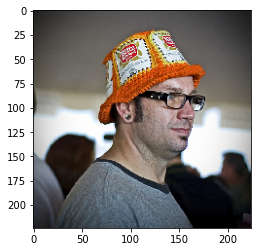

In [140]:

picture = '1007129816_e794419615.jpg'
filename = r'C:\Users\mohan\Desktop\Kaggle_competition\Image_Captioning\8k_dataset\623289_1111676_bundle_archive\Images\{}'.format(picture)

# load and prepare the photograph
photo=extract_features(filename)

# generate description
description = generate_desc(model, tokenizer, photo, max_length)

#print(description)
query = description
stopwords = ['startseq','endseq']
querywords = query.split()
resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)
print('I think it is : ',result)

pp = load_img(filename, target_size=(224, 224))
# convert the image pixels to a numpy array
pp = img_to_array(pp)
pp=np.array(pp)
pp=pp/255.0
plt.imshow(pp)
plt.show()

# Model evaluation with BLUE score

In [3]:
descriptions = dict(zip(cap['caption'],cap['image'] ))

In [94]:
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu,SmoothingFunction

In [141]:

# evaluate the skill of the model
def evaluate_model(model, descriptions, features, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for desc_list,key in descriptions.items():
        # generate description
        ky = key.split('.')[0]
        yhat = generate_desc(model, tokenizer, features[ky], max_length)
        query = yhat
        stopwords = ['startseq','endseq']
        querywords = query.split()
        resultwords  = [word for word in querywords if word.lower() not in stopwords]
        result = ' '.join(resultwords)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(result.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [142]:
evaluate_model(model, descriptions, features, tokenizer, max_length)

BLEU-1: 0.000000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
